# Introduction

Here we are using dataset that contains the information about individuals from various countries. Our target is to predict whether a person makes <=50k or >50k annually on basis of the other information available. Dataset consists of 32561 observations and 14 features describing individuals.

Here is the link to the dataset: http://archive.ics.uci.edu/ml/datasets/Adult.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier, LGBMModel
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score, roc_curve, auc
from datetime import datetime

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
columns=['age','workclass','fnlwgt','education','education-num','marital_Status','occupation','relationship',
         'race','sex','capital_gain','capital_loss','hours_per_week','native_country','Income'] 
train= pd.read_csv('adult.csv',names=columns, )

In [3]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital_Status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
test= pd.read_csv('adult_test.csv',names=columns, skiprows=[0])

In [5]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital_Status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
test['Income']= test['Income'].apply(lambda x: x[0:-1])

In [7]:
train['source']='train'
test['source']='test'
data= pd.concat([train,test],axis=0,ignore_index=True)

In [8]:
#no missing values
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital_Status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
Income            0
source            0
dtype: int64

Encoding the target variable

In [9]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
data['Income']= le.fit_transform(data['Income'])

data['Income'].value_counts()

0    37155
1    11687
Name: Income, dtype: int64

In [10]:
data.describe()

,age,fnlwgt,education-num,capital_gain,capital_loss,hours_per_week,Income
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


By this we can see we need to scale values

In [11]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital_Status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
Income             int64
source            object
dtype: object

In [12]:
#separating the categorical and numerical variables
cat= [x for x in data.columns if data[x].dtype=='object']
num= [x for x in data.columns if data[x].dtype=='int64']

In [13]:
cat

['workclass',
 'education',
 'marital_Status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'source']

In [14]:
cat.remove('source') # as we dont need saource to categorize

In [15]:
num

['age',
 'fnlwgt',
 'education-num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'Income']

In [16]:
num.remove('Income') #as income is dependent var, we dont want to scale it

Checking the different categories in different columns

In [17]:
for i in cat:
    print(data[i].value_counts())

 Private             33906
 Self-emp-not-inc     3862
 Local-gov            3136
 ?                    2799
 State-gov            1981
 Self-emp-inc         1695
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64
 HS-grad         15784
 Some-college    10878
 Bachelors        8025
 Masters          2657
 Assoc-voc        2061
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           955
 Prof-school       834
 9th               756
 12th              657
 Doctorate         594
 5th-6th           509
 1st-4th           247
 Preschool          83
Name: education, dtype: int64
 Married-civ-spouse       22379
 Never-married            16117
 Divorced                  6633
 Separated                 1530
 Widowed                   1518
 Married-spouse-absent      628
 Married-AF-spouse           37
Name: marital_Status, dtype: int64
 Prof-specialty       6172
 Craft-repair         6112
 Exec-managerial

In Some columns we can see '?' we can either change them to unknown or can leave it as it is as we have to create one hot encoding

# One Hot Encoding

In [18]:
data= pd.get_dummies(data,columns=cat, drop_first=True)

In [19]:
data.head()

,age,fnlwgt,education-num,capital_gain,capital_loss,hours_per_week,Income,source,workclass_ Federal-gov,workclass_ Local-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,77516,13,2174,0,40,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,train,0,0,...,0,0,0,0,0,0,0,0,0,0


# Scaling

In [20]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()

In [21]:
data.loc[:,num]= ss.fit_transform(data.loc[:,num])

In [22]:
data.head()

,age,fnlwgt,education-num,capital_gain,capital_loss,hours_per_week,Income,source,workclass_ Federal-gov,workclass_ Local-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087,0,train,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087,0,train,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
train= data.loc[data['source']=='train',:]
test= data.loc[data['source']=='test',:]

In [24]:
x_train= train.drop(['Income','source'],axis=1)
y_train= train['Income']

In [25]:
x_train.shape

(32561, 100)

In [26]:
y_train.shape

(32561,)

In [27]:
x_test= test.drop(['Income','source'],axis=1)
y_test= test['Income']

# XGboost

In [28]:
from xgboost import XGBClassifier

start= datetime.now()
model = XGBClassifier()

# fit the model with the training data
model.fit(x_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(x_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)
print('roc_score on train dataset : ', roc_auc_score(y_train,predict_train))
print('Report on train dataset : ','\n', classification_report(y_train,predict_train))

# predict the target on the test dataset
predict_test = model.predict(x_test)

print('*'*30)
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print('roc_score on test dataset : ', roc_auc_score(y_test,predict_test))
print('Report on test dataset : ','\n', classification_report(y_test,predict_test))
end= datetime.now()

date_diff= end-start
print('time diff', date_diff)


accuracy_score on train dataset :  0.8664045944534873
roc_score on train dataset :  0.7744255106239751
Report on train dataset :  
               precision    recall  f1-score   support

           0       0.88      0.95      0.92     24720
           1       0.80      0.60      0.68      7841

    accuracy                           0.87     32561
   macro avg       0.84      0.77      0.80     32561
weighted avg       0.86      0.87      0.86     32561

******************************

accuracy_score on test dataset :  0.8692340765309257
roc_score on test dataset :  0.775659858722455
Report on test dataset :  
               precision    recall  f1-score   support

           0       0.88      0.95      0.92     12435
           1       0.80      0.60      0.68      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.78      0.80     16281
weighted avg       0.86      0.87      0.86     16281

time diff 0:00:20.445956


# Modeling USing LGBM

In [29]:
start= datetime.now()
model = LGBMClassifier()

# fit the model with the training data
model.fit(x_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(x_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)
print('roc_score on train dataset : ', roc_auc_score(y_train,predict_train))
print('Report on train dataset : ','\n', classification_report(y_train,predict_train))

# predict the target on the test dataset
predict_test = model.predict(x_test)

print('*'*30)
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print('roc_score on test dataset : ', roc_auc_score(y_test,predict_test))
print('Report on test dataset : ','\n', classification_report(y_test,predict_test))
end= datetime.now()

date_diff= end-start
print('time diff', date_diff)


accuracy_score on train dataset :  0.8874113202911459
roc_score on train dataset :  0.8196969481222467
Report on train dataset :  
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     24720
           1       0.81      0.69      0.75      7841

    accuracy                           0.89     32561
   macro avg       0.86      0.82      0.84     32561
weighted avg       0.88      0.89      0.88     32561

******************************

accuracy_score on test dataset :  0.8732878815797556
roc_score on test dataset :  0.7966320655238754
Report on test dataset :  
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     12435
           1       0.78      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.80      0.81     16281
weighted avg       0.87      0.87      0.87     16281

time diff 0:00:01.271896


## Comparing with XGboost

Now we can check with default parameter LightGBM took 1 sec and XGboost took 20 sec and accuracy and roc_auc is higher for Light GBM

# Evaluation metrics of Light GBM model

# ROC-AUC

In [30]:
yprob= model.predict_proba(x_test)
yprob= [x[1] for x in yprob]
fpr,tpr,threshold= roc_curve(y_test,yprob)

Text(0.5, 1.0, '0.9274763873546498')

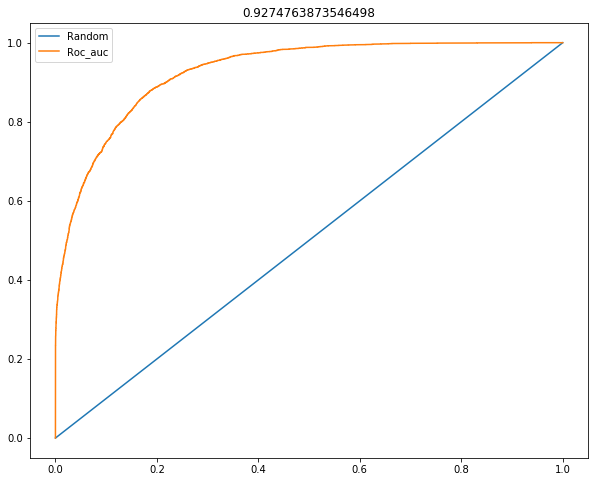

In [31]:
plt.figure(figsize=(10,8))
plt.plot((0,1),(0,1), label='Random')
plt.plot(fpr,tpr, label='Roc_auc')
plt.legend(loc='best')
plt.title(auc(fpr,tpr))

In [32]:
from sklearn.metrics import auc, log_loss, precision_recall_curve, f1_score, precision_score,recall_score

In [33]:
auc(fpr,tpr)

0.9274763873546498

# Gini Coefficient

Gini coefficient is sometimes used in classification problems. Gini coefficient can be straigh away derived from the AUC ROC number. Gini is nothing but ratio between area between the ROC curve and the diagnol line & the area of the above triangle. Following is the formulae used :

Gini = 2*AUC – 1

Gini above 60% is a good model. For the case in hand we get Gini as 92.7%.

In [34]:
Gini= 2*auc(fpr,tpr)-1
Gini

0.8549527747092995

In [35]:
#(auc of roc-auc - auc of diagonal)/auc of diagonal
(auc(fpr,tpr)-auc((0,1),(0,1)))/auc((0,1),(0,1))

0.8549527747092995

# KS Score

K-S is a measure of the degree of separation between the positive and negative distributions. 

In [36]:
p= model.predict_proba(x_test)
p= p[:,1]

df= pd.DataFrame({'prob':p, 'target':y_test},)

from scipy.stats import ks_2samp
ks_2samp(df.loc[df.target==0,"prob"], df.loc[df.target==1,"prob"])


Ks_2sampResult(statistic=0.6921712091644101, pvalue=0.0)

It returns KS score 69% and p-value less than 0.01 which means we can reject the null hypothesis and concluding distribution of events and non-events is different.

In [37]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [38]:
mydf = ks(data=df,target='target', prob="prob")

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.752489  0.999169    1521        106     39.55%         0.85%   
2       0.495413  0.752456     998        631     25.95%         5.07%   
3       0.298747  0.495229     618       1010     16.07%         8.12%   
4       0.155149  0.298342     387       1241     10.06%         9.98%   
5       0.072523  0.155117     196       1432      5.10%        11.52%   
6       0.032839  0.072412      71       1557      1.85%        12.52%   
7       0.015674  0.032832      36       1592      0.94%        12.80%   
8       0.007678  0.015669      14       1614      0.36%        12.98%   
9       0.002366  0.007677       3       1625      0.08%        13.07%   
10      0.000175  0.002365       2       1627      0.05%        13.08%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             39.55

The KS score of method 1 is slightly different from method 2 as first one is calculated at row level and the second one is calculated after converting data into ten parts.

# Concordance

In [39]:
p= model.predict_proba(x_test)
p= p[:,1]

df= pd.DataFrame({'prob':p, 'target':y_test},)

In [40]:
event= df.loc[df.target==1,"prob"]
non_event= df.loc[df.target==0,"prob"]

In [41]:
pair=[]
for i in event:
    for j in non_event:
        pair.append([i,j])

In [42]:
con=0
discon=0
for i in pair:
    if i[0]>i[1]:
        con = con+1
    else:
        discon= discon+1

print(con,discon)

44356469 3468541


In [43]:
con_ratio= con/len(pair)
discon_ratio= discon/len(pair)
print(con_ratio,discon_ratio)

0.927474327762817 0.07252567223718301


As concordance ratio is higher than dis concardant so model is good.

# Log_Loss

log loss which is nothing but negative average of the log of corrected predicted probabilities for each instance.

In [44]:
log_loss(y_test,model.predict(x_test))

4.376516983726144

# Precision Recall Curve

In [45]:
yprob= model.predict_proba(x_test)
yprob= [x[1] for x in yprob]
p,r,t = precision_recall_curve(y_test,yprob)

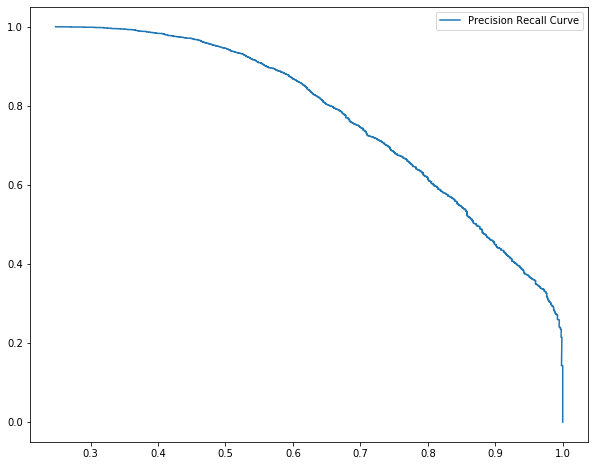

In [46]:
plt.figure(figsize=(10,8))
plt.plot(p,r, label='Precision Recall Curve')
plt.legend(loc='best')


In [47]:
f1_score(y_test,model.predict(x_test))

0.7083274423865404

In [48]:
precision_score(y_test,model.predict(x_test))

0.776262782770375

In [49]:
recall_score(y_test,model.predict(x_test))

0.6513260530421217

All three score says it is a good model